# Load and explore the data set

In [1]:
# Load dataset
import pandas as pd
data = pd.read_csv('banking.csv')

# Have a quick look 
data.head()

age          job  marital          education  default housing loan  \
0   44  blue-collar  married           basic.4y  unknown     yes   no   
1   53   technician  married            unknown       no      no   no   
2   28   management   single  university.degree       no     yes   no   
3   39     services  married        high.school       no      no   no   
4   55      retired  married           basic.4y       no     yes   no   

    contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  cellular   aug         thu  ...         1    999         0  nonexistent   
1  cellular   nov         fri  ...         1    999         0  nonexistent   
2  cellular   jun         thu  ...         3      6         2      success   
3  cellular   apr         fri  ...         2    999         0  nonexistent   
4  cellular   aug         fri  ...         1      3         1      success   

  emp_var_rate  cons_price_idx  cons_conf_idx  euribor3m  nr_employed  y  
0          1.4          93.444          -36.1      4.963       5228.1  0  
1         -0.1          93.200          -42.0      4.021       5195.8  0  
2         -1.7          94.055          -39.8      0.729       4991.6  1  
3         -1.8          93.075          -47.1      1.405       5099.1  0  
4         -2.9          92.201          -31.4      0.869       5076.2  1  

[5 rows x 21 columns]

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [2]:
import numpy as np
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns.

In [3]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

# Explore data set 

### There are many 'unknown' value in this data frame, we should delete them

In [4]:
# Delete 'unknown' value

cat_cols = data.select_dtypes(include=object).columns.tolist()

for col in cat_cols:
    # delete each columns that has value 'unknown' 
    index_names = data[ data[col] == 'unknown' ].index 
  
    # drop these row indexes from dataFrame 
    data.drop(index_names, inplace = True) 

### Question:
We should delete 'default' because the label is super imbalance
(Let's explore later how this will effect our result)

In [5]:
data = data.drop("default", axis=1)

# Calculating auc score difference before and after Oversampling using SMOTE

In [12]:
def auc_score_diff(data, ratio):
    
    """
    This function return the difference of percentage of auc score before and after oversampling using SMOTE.
    """
    assert ratio >= 7, "Argument 'ratio' out of range"
    
    # downsample the dataset that defaulted
    from sklearn.utils import resample

    df_no_subscribed = data[data['y'] == 0]
    df_subscribed = data[data['y'] == 1]

    # create label ratio
    n_samples = round(data['y'].copy().value_counts()[1] * ratio - data['y'].copy().value_counts()[0])

    df_no_subscribed_downsampled = resample(df_no_subscribed,
                                 replace=True,
                                 n_samples=n_samples,
                                 random_state=1818)


    data = pd.concat([data, df_no_subscribed_downsampled])
    
    # Split X and y
    X = data.drop('y', axis=1).copy()
    y = data['y'].copy()
    
    # One-hot Encoding
    cat_cols = data.select_dtypes(include=object).columns.tolist()
    X_encoded = pd.get_dummies(X, columns=cat_cols)
    X_encoded.head()
    
    # Split training and testing set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)
    
    # Build model before oversampling
    from sklearn.linear_model import LogisticRegression
    clf_lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.26)
    clf_lr.fit(X_train, y_train)
    
    from sklearn.metrics import roc_auc_score
    
    fir_score = roc_auc_score(y_test, clf_lr.decision_function(X_test))
    
    # Oversampling
    from imblearn.over_sampling import SMOTE

    os = SMOTE(random_state=0)
    columns = X_train.columns

    os_data_X,os_data_y=os.fit_resample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    
    X_train_new = os_data_X
    y_train_new = os_data_y
    
    clf_lr_after = LogisticRegression(penalty='l1', solver='liblinear', C=1.26)
    clf_lr_after.fit(X_train_new, y_train_new)
    
    sec_score = roc_auc_score(y_test, clf_lr_after.decision_function(X_test))
    
    return (sec_score - fir_score) * 100


In [ ]:
auc_score_diff(data, 500)

In [47]:
x = np.arange(1, 6, 0.1)
x

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

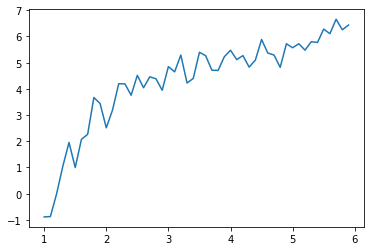

In [49]:
import matplotlib.pyplot as plt
x = np.arange(1, 6, 0.1)
y = [auc_score_diff(data, ratio) for ratio in x]
plt.plot(x, y)

In [50]:
saved_y = y

In [54]:
plt.plot(x, y)
plt.xlim([1, 6])
plt.ylim([0, 10])
plt.xlabel('Label Ratio')
plt.ylabel('AUC Score Difference')
plt.legend(loc="lower right")
plt.savefig('ASD LR')
plt.show()

No handles with labels found to put in legend.


In [10]:
# downsample the dataset that defaulted
from sklearn.utils import resample

df_no_subscribed = data[data['y'] == 0]
df_subscribed = data[data['y'] == 1]

ratio = 500
# create label ratio
n_samples = round(data['y'].copy().value_counts()[1] * ratio - data['y'].copy().value_counts()[0])

df_no_subscribed_downsampled = resample(df_no_subscribed,
                             replace=True,
                             n_samples=n_samples,
                             random_state=1818)


data = pd.concat([data, df_no_subscribed_downsampled])

In [11]:
data['y'].value_counts()

0    1929500
1       3859
Name: y, dtype: int64

# The End 